<a href="https://colab.research.google.com/github/masrik-dev/skimlit-nlp-project/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SkimLit: Research Paper Abstract Classification (PubMed 200k RCT Dataset)**

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

📖 **Resource:**
1. The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

2. And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251


In [1]:
# # Confirm access to a GPU
# !nvidia-smi -L

# **Data Preparation**

## Get the data

Since, we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


### Some instructions from the author regarding the `PubMed 200k RCT` dataset.

Some miscellaneous information:

* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use [7-Zip](http://www.7-zip.org/download.html) on Windows, [Keka](http://www.kekaosx.com/en/) on Mac OS X, or [p7zip](http://p7zip.sourceforge.net/) on Linux.

You are most welcome to share with us your analyses or work using this dataset!

**We would like to express our gratitude to the authors for making this valuable dataset publicly available.**

In [3]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

Here, the `train` datset is in `.zip` file. We need to unzip `train.zip` first.

In [6]:
import zipfile
import os

zip_path = data_dir + "train.zip"
extract_dir = data_dir

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [7]:
os.listdir(data_dir)

['train.txt', 'dev.txt', 'train.zip', 'test.txt']

In [12]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target file.
  """
  with open(filename, "r") as f:
    return f.readlines()  # This reads the remaining lines from the file object and returns them as a list.


In [13]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

## Data Preprocessing

In [14]:
# Function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as file:
    return file.readlines()

# Read in the training lines
train_lines = get_lines(data_dir + 'train.txt')

In [15]:
def preprocess_text_with_lines(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)  # Get all lines from filename
  abstract_lines = ""  # Create an empty abstract
  abstract_samples = []  # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""   # Reset the abstract string if the line starts with "###"
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}  # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")  # Split target label from text
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()  # Get target text and lower it
        line_data["line_number"] = abstract_line_number   # What number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)  # Append line data to abstract samples lsit
    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [16]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_lines(data_dir + "train.txt")
val_samples = preprocess_text_with_lines(data_dir + "dev.txt")
test_samples = preprocess_text_with_lines(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

2211861 28932 29493
CPU times: user 3.76 s, sys: 953 ms, total: 4.71 s
Wall time: 4.79 s


In [17]:
# Turn the abstract lines into DataFrames
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [18]:
# Distribution of labels in the training data
train_df["target"].value_counts()

,count
target,
RESULTS,766271
METHODS,722586
CONCLUSIONS,339714
BACKGROUND,196689
OBJECTIVE,186601


In [19]:
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


Text(0.5, 1.0, 'Distribution of Total Lines in Training Data')

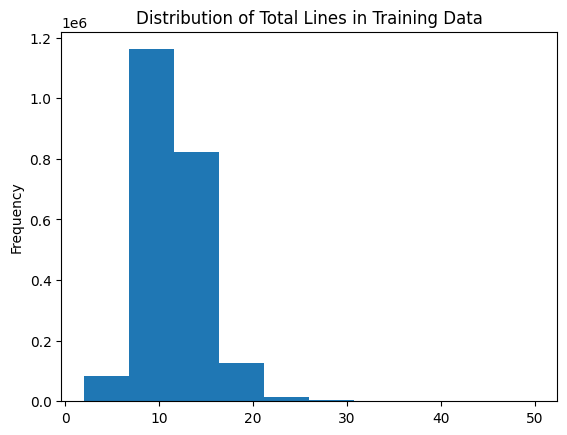

In [20]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()
plt.title("Distribution of Total Lines in Training Data")

In [23]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [24]:
# View the 10 lines of training sentences
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

### Convert Labels to Numeric Format

Convert categorical labels into numeric form (e.g., one-hot encoding) so they can be used by machine learning models.

In [27]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
print(f"Train labels:\n {train_labels_one_hot},\n\nVal_labels:\n {val_labels_one_hot},\n\nTest labels:\n {test_labels_one_hot}")


Train labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]],

Val_labels:
 [[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]],

Test labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


### Label Encode Labels

In [28]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [31]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f"Number of classes: {num_classes}\nClass names: {class_names}")

Number of classes: 5
Class names: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


# **Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings**

## Character Embeddings

###